# build a new complex to increase border preserving property
1. clustering training dataset(minhash)
2. connect CP to the K nearest DPs
3. use those edges to train a dimension reduction autoencoder

## import modules

In [1]:
import torch
import math
import time
import numpy as np
from sklearn.cluster import DBSCAN

In [2]:
# hyperparameters
data_shape = (2048,)
n_hidden = 500
dim_z = 2

# train
n_epochs = 500
batch_size = 200
learn_rate = 0.001

In [3]:
train_data = np.load("train_data.npy")
train_pred_labels = np.load("train_pred_labels.npy")

In [4]:
test_data = np.load("test_data.npy")
test_pred_labels = np.load("test_pred_labels.npy")

In [5]:
border_center = np.load("border_center.npy")
border_center_labels= np.load("border_center_labels.npy")
augmentation_data = np.load("augmentation_data.npy")
border_center.shape, border_center_labels.shape, augmentation_data.shape

((5000, 2048), (5000,), (50000, 2048))

In [6]:
# define encoder
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

## Clustering
LSH not suitable
because lsh has the property that similar points would fall into the same bucket AB BC is close don't mean that AC is close

In [7]:
centers = np.load("centers.npy")

# build a new complex
- nndescent is can find the nearest neighbors inside the dataset
- here I choose random projection forest
(KDTree may be alternative solution?)

In [8]:
## nndescent?
from sklearn.neighbors import KDTree
high_tree = KDTree(border_center) 

In [9]:
from sklearn.utils import check_random_state
random_state = check_random_state(None)

In [10]:
fitting_data = np.concatenate((centers, border_center),axis=0)

In [11]:
# fuzzy simplicial set
knn_dists, knn_indices = high_tree.query(fitting_data, k=30) 

In [12]:
knn_indices = knn_indices+len(centers)

### asymmetric

In [13]:
from umap.umap_ import smooth_knn_dist,compute_membership_strengths
import scipy
def fuzzy_simplicial_set(X,random_state,n_neighbors,knn_indices,knn_dists):
    
    knn_dists = knn_dists.astype(np.float32)

    sigmas, rhos = smooth_knn_dist(
        knn_dists, float(n_neighbors), local_connectivity=float(1),
    )

    rows, cols, vals, dists = compute_membership_strengths(
        knn_indices, knn_dists, sigmas, rhos, return_dists=False
    )

    result = scipy.sparse.coo_matrix(
        (vals, (rows, cols)), shape=(X.shape[0], X.shape[0])
    )
    result.eliminate_zeros()
    return result

In [14]:
new_complex = fuzzy_simplicial_set(
    X=fitting_data,
    random_state=random_state,
    n_neighbors=30,
    knn_indices=knn_indices,
    knn_dists=knn_dists,
)

### symmetric

In [13]:
# symmetric
from umap.umap_ import fuzzy_simplicial_set

In [14]:
# build fuzzy_simplicial_set
new_complex, sigmas, rhos = fuzzy_simplicial_set(
    X = fitting_data,
    n_neighbors = 30,
    metric = "euclidean",
    random_state = random_state,
    knn_indices= knn_indices,
    knn_dists = knn_dists,
)

In [15]:
# number of trees in random projection forest
n_trees = min(64, 5 + int(round((fitting_data.shape[0]) ** 0.5 / 20.0)))
# max number of nearest neighbor iters to perform
n_iters = max(5, int(round(np.log2(fitting_data.shape[0]))))
# distance metric
metric = "euclidean"
# number of neighbors for computing k-neighbor graph
n_neighbors = 30

from pynndescent import NNDescent
# get nearest neighbors
nnd = NNDescent(
    train_data,
    n_neighbors=n_neighbors,
    metric=metric,
    n_trees=n_trees,
    n_iters=n_iters,
    max_candidates=60,
    verbose=True
)

Wed Jan 27 16:52:28 2021 Building RP forest with 10 trees
Wed Jan 27 16:52:30 2021 NN descent for 13 iterations
	 1  /  13
	 2  /  13
	Stopping threshold met -- exiting after 2 iterations


In [16]:
from sklearn.utils import check_random_state
from umap.umap_ import fuzzy_simplicial_set
knn_indices, knn_dists = nnd.neighbor_graph
random_state = check_random_state(None)
old_complex, sigmas, rhos = fuzzy_simplicial_set(
    X=train_data,
    n_neighbors=n_neighbors,
    metric=metric,
    random_state=random_state,
    knn_indices=knn_indices,
    knn_dists=knn_dists,
)

## define autoencoder

In [17]:
# from parametric_umap_DBP import construct_edge_dataset
# from parametric_umap_DBP import umap_loss
from parametric_umap_DBP import construct_mixed_edge_dataset
from parametric_umap_DBP import umap_loss
# from parametric_umap_DBP import tpdbp_loss

In [18]:
dims = (2048,)
n_components = 2

n_epochs = 200 

In [19]:
encoder = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=dims),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=1024, activation="relu"),
    tf.keras.layers.Dense(units=n_components),
])
encoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              2098176   
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 2050      
Total params: 2,100,226
Trainable params: 2,100,226
Non-trainable params: 0
_________________________________________________________________


In [20]:
# define the decoder
decoder = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(n_components)),
    tf.keras.layers.Dense(units=1024, activation="relu"),
    tf.keras.layers.Dense(units=np.product(dims), name="recon", activation=None),
    tf.keras.layers.Reshape(dims),

])
decoder.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 1024)              3072      
_________________________________________________________________
recon (Dense)                (None, 2048)              2099200   
_________________________________________________________________
reshape (Reshape)            (None, 2048)              0         
Total params: 2,102,272
Trainable params: 2,102,272
Non-trainable params: 0
_________________________________________________________________


In [ ]:
## TODO
# change construct_edge_dataset, so that the mixed complex can be construct

In [21]:
(
    new_edge_dataset,
    batch_size,
    n_edges,
    edge_weight,
) = construct_mixed_edge_dataset(
    (train_data, centers, border_center),
    old_complex,
    new_complex,
    n_epochs,
    batch_size,
    parametric_embedding = True,
    parametric_reconstruction = True,
)

In [22]:
# define model
# network outputs
outputs = {}

# inputs
to_x = tf.keras.layers.Input(shape=dims, name="to_x")
from_x = tf.keras.layers.Input(shape=dims, name="from_x")
weight = tf.keras.layers.Input(shape=(1, ), name="weight")
inputs = (to_x, from_x, weight)

# parametric embedding
embedding_to = encoder(to_x)
embedding_from = encoder(from_x)

# parametric reconstruction
embedding_to_recon = decoder(embedding_to)

embedding_to_recon = tf.keras.layers.Lambda(
    lambda x: x, name="reconstruction"
)(embedding_to_recon)

outputs["reconstruction"] = embedding_to_recon

# concatenate to/from projections for loss computation
embedding_to_from = tf.concat((embedding_to, embedding_from, weight), axis=1)
embedding_to_from = tf.keras.layers.Lambda(lambda x: x, name="umap")(
    embedding_to_from
)

# weights = tf.keras.layers.Lambda(lambda x: x, name="weights")(
#     weight
# )


outputs["umap"] = embedding_to_from

# outputs["weights"] = weights

# create model
parametric_model = tf.keras.Model(inputs=inputs, outputs=outputs,)

In [23]:
from umap.umap_ import find_ab_params
min_dist = 0.1
_a, _b = find_ab_params(1.0, min_dist)

In [24]:
negative_sample_rate = 5
optimizer = tf.keras.optimizers.Adam(1e-3)

In [25]:
def lr_schedule(epoch):
    """Learning Rate Schedule

    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.

    # Arguments
        epoch (int): The number of epochs

    # Returns
        lr (float32): learning rate
    """
    lr = 1e-3
    if epoch > 5:
        lr *= 1e-1
    elif epoch > 15:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr

callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        min_delta=10**-2,
        patience=10,
        verbose=1,
    ),
    tf.keras.callbacks.TensorBoard(log_dir='logs/mse/',histogram_freq=1),
    tf.keras.callbacks.LearningRateScheduler(lr_schedule),
#     tf.keras.callbacks.ReduceLROnPlateau(factor=np.sqrt(0.1),
#                                cooldown=0,
#                                patience=5,
#                                min_lr=0.5e-6)
]

In [26]:
#compile models
losses = {}
loss_weights = {}

umap_loss_fn = umap_loss(
    batch_size,
    negative_sample_rate,
    _a,
    _b,
    edge_weight,
    True,
)

losses["umap"] = umap_loss_fn
loss_weights["umap"] = 1.0

# losses["weights"] = tpdbp_loss_fn
# loss_weights["weights"] = 0.1

losses["reconstruction"] = tf.keras.losses.MeanSquaredError()
loss_weights["reconstruction"] = 1.0

parametric_model.compile(
    optimizer=optimizer, loss=losses, loss_weights=loss_weights,
)

## fitting model

In [27]:
steps_per_epoch = int(
    n_edges / batch_size / 10
)
# val_steps_per_epoch = int(
#     val_n_edges / batch_size / 5
# )

In [28]:
# create embedding
history = parametric_model.fit(
    new_edge_dataset,
    epochs=20,
    steps_per_epoch=steps_per_epoch,
    callbacks=callbacks,
    max_queue_size=100,
    
)

Epoch 1/20
Learning rate:  0.001
16374/16374 [==============================] - 132s 8ms/step - loss: 0.1563 - reconstruction_loss: 0.0015 - umap_loss: 0.1548
Epoch 2/20
Learning rate:  0.001
16374/16374 [==============================] - 131s 8ms/step - loss: 0.1366 - reconstruction_loss: 0.0011 - umap_loss: 0.1355
Epoch 3/20
Learning rate:  0.001
16374/16374 [==============================] - 130s 8ms/step - loss: 0.1271 - reconstruction_loss: 8.1610e-04 - umap_loss: 0.1263
Epoch 4/20
Learning rate:  0.001
16374/16374 [==============================] - 136s 8ms/step - loss: 0.1243 - reconstruction_loss: 6.8626e-04 - umap_loss: 0.1236
Epoch 5/20
Learning rate:  0.001
16374/16374 [==============================] - 134s 8ms/step - loss: 0.1254 - reconstruction_loss: 7.3806e-04 - umap_loss: 0.1247
Epoch 6/20
Learning rate:  0.001
16374/16374 [==============================] - 134s 8ms/step - loss: 0.1225 - reconstruction_loss: 7.1296e-04 - umap_loss: 0.1218
Epoch 7/20
Learning rate:  0.0

In [29]:
import matplotlib.pyplot as plt

In [30]:
history.history.keys()

dict_keys(['loss', 'reconstruction_loss', 'umap_loss', 'lr'])

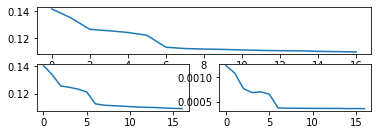

In [31]:
plt.figure(1)
plt.subplot(411)
plt.plot(history.history['loss'])
plt.subplot(423)
plt.plot(history.history['umap_loss'])
plt.subplot(424)
plt.plot(history.history['reconstruction_loss'])
# plt.subplot(413)
# plt.plot(history.history['val_loss'])
# plt.subplot(427)
# plt.plot(history.history['val_umap_loss'])
# plt.subplot(428)
# plt.plot(history.history['val_reconstruction_loss'])

In [32]:
z = encoder.predict(train_data)

Text(0.5, 1.0, 'UMAP embeddings')

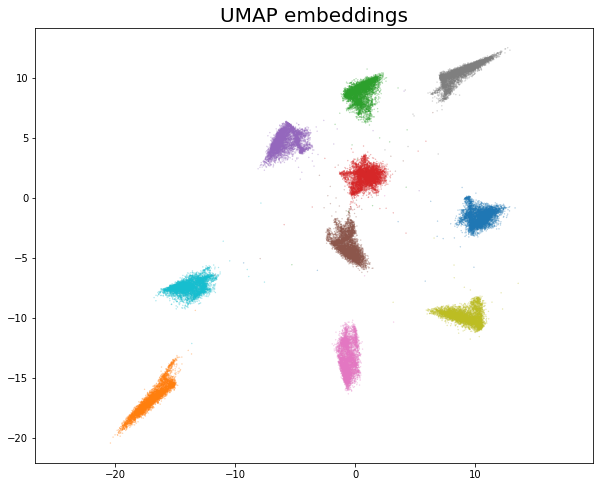

In [33]:
fig, ax = plt.subplots(ncols=1, figsize=(10, 8))
sc = ax.scatter(
    z[:, 0],
    z[:, 1],
    c=train_pred_labels,
    cmap="tab10",
    s=0.1,
    alpha=0.5,
    rasterized=True,
)
ax.axis('equal')
ax.set_title("UMAP embeddings", fontsize=20)

In [34]:
# save
import os

save_location = "parametric_umap_models\dbp_exp"
# # save encoder
encoder_output = os.path.join(save_location, "encoder_mixed_complex_30")
encoder.save(encoder_output)
print("Keras encoder model saved to {}".format(encoder_output))

# # save decoder
decoder_output = os.path.join(save_location, "decoder_mixed_complex_30")
decoder.save(decoder_output)
print("Keras decoder model saved to {}".format(decoder_output))


FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.
INFO:tensorflow:Assets written to: parametric_umap_models\dbp_exp\encoder_mixed_complex_30\assets
Keras encoder model saved to parametric_umap_models\dbp_exp\encoder_mixed_complex_30

FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.
INFO:tensorflow:Assets written to: parametric_umap_models\dbp_exp\decoder_mixed_complex_30\assets
Keras decoder model saved to parametric_umap_models\dbp_exp\decoder_mixed_complex_30


In [15]:
import os
save_location = "parametric_umap_models\dbp_exp"
# load model
# load encoder
encoder_output = os.path.join(save_location, "encoder_core_complex_15")
if os.path.exists(encoder_output):
    encoder = tf.keras.models.load_model(encoder_output)
    print("Keras encoder model loaded from {}".format(encoder_output))
    
decoder_output = os.path.join(save_location, "decoder_core_complex_15")
if os.path.exists(decoder_output):
    decoder = tf.keras.models.load_model(decoder_output)
    print("Keras encoder model loaded from {}".format(decoder_output))

Keras encoder model loaded from parametric_umap_models\dbp_exp\encoder_core_complex_15
Keras encoder model loaded from parametric_umap_models\dbp_exp\decoder_core_complex_15


# Investigate 2 research questions:
1. knn = 0, those points are a part of center?
2. If is true, then training has a problem,if false, then further training

In [16]:
low_center = encoder(border_center).cpu().numpy()
low_train = encoder(train_data).cpu().numpy()
from sklearn.neighbors import KDTree
high_tree = KDTree(border_center) 
low_tree = KDTree(low_center)

Instructions for updating:
Use tf.identity instead.


In [17]:
# k=15
_, high_ind = high_tree.query(train_data, k=10) 
_, low_ind = low_tree.query(low_train, k=10)
border_pres = np.zeros(len(train_data))
for i in range(len(train_data)):
    border_pres[i] = len(np.intersect1d(high_ind[i],low_ind[i]))
# new complex core K=10
border_pres.mean(), border_pres.max(),border_pres.min()

(2.8041, 10.0, 0.0)

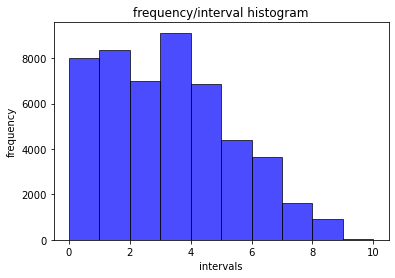

In [19]:
# diagram of positive samples
import matplotlib.pyplot as plt
import numpy as np
import matplotlib

"""
绘制直方图
data:必选参数，绘图数据
bins:直方图的长条形数目，可选项，默认为10
normed:是否将得到的直方图向量归一化，可选项，默认为0，代表不归一化，显示频数。normed=1，表示归一化，显示频率。
facecolor:长条形的颜色
edgecolor:长条形边框的颜色
alpha:透明度
"""
plt.hist(border_pres, bins=10, density=0, stacked=True, facecolor="blue", edgecolor="black", alpha=0.7)
# 显示横轴标签
plt.xlabel("intervals")
# 显示纵轴标签
plt.ylabel("frequency")
# 显示图标题
plt.title("frequency/interval histogram")
plt.show()

In [21]:
# k=15
low_centers = encoder(centers).cpu().numpy()
_, high_ind = high_tree.query(centers, k=10) 
_, low_ind = low_tree.query(low_centers, k=10)
border_pres = np.zeros(len(centers))
for i in range(len(centers)):
    border_pres[i] = len(np.intersect1d(high_ind[i],low_ind[i]))
# new complex core K=10
border_pres.mean(), border_pres.max(),border_pres.min()

(2.8694, 10.0, 0.0)

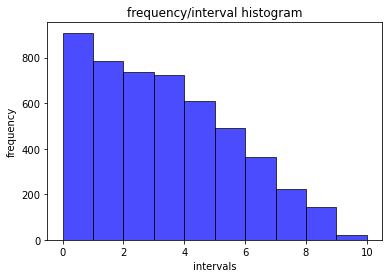

In [22]:
plt.hist(border_pres, bins=10, density=0, stacked=True, facecolor="blue", edgecolor="black", alpha=0.7)
# 显示横轴标签
plt.xlabel("intervals")
# 显示纵轴标签
plt.ylabel("frequency")
# 显示图标题
plt.title("frequency/interval histogram")
plt.show()